# Exploretory data analysis (EDA)

For the first step, we look at the arXiv dataset to find the basic trends, and to clean the dataset to make it ready for the machine learning algorithm.

Let's import necessary libraries.

In [105]:
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from sklearn.preprocessing import MultiLabelBinarizer
import altair as alt

In [106]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
DATA_PATH = '../input/archive/arxiv-metadata-oai-snapshot.json'

This dataset is huge (It has 1.9M+ rows). To use only limited memory, we open just the first 20000 rows, and save that on the disk.

In [108]:
df = pd.read_json(DATA_PATH, lines=True, nrows=20000)

In [109]:
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


In [110]:
df.to_csv('../input/arxiv_20krows.csv', index=False)

In [111]:
df_20k = pd.read_csv('../input/arxiv_20krows.csv')

In [112]:
print("Number of rows in data =",df_20k.shape[0])
print("Number of columns in data =",df_20k.shape[1])

Number of rows in data = 20000
Number of columns in data = 14


In [113]:
## check for Null values
df_20k.isnull().sum()

id                    0
submitter             0
authors               0
title                 0
comments           2349
journal-ref        9501
doi                7416
report-no         18107
categories            0
license           18514
abstract              0
versions              0
update_date           0
authors_parsed        0
dtype: int64

Many rows of `comments`, `journal-ref`, `doi`, `report-no` and `license` columns are empty. But we need in our project is the `title`, `abstract` and `categories` columns, there are no null values in those columns.

Let's look at a sample `abstract`:

In [9]:
df_20k['abstract'][0]

'  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with data from the Fermilab Tevatron, and predictions are made for\nmore detailed tests with CDF and DO data. Predictions are shown for\ndistributions of diphoton pairs produced at the energy of the Large Hadron\nCollider (LHC). Distributions of the diphoton pairs from the decay of a Higgs\nboson are contrasted with those produced from QCD processes at the LHC, showing\nthat enhanced sensitivity to the signal can be obtained with judicious\nselection of events.\n'

The category of articles are in the `categories` column, and they are seprated with a space character. So to get each category for each sample in our dataset, we need to split the values in the `categories` column by space character:

In [115]:
df_20k['cats_split'] = df_20k['categories'].str.split()

How many categories exist in the dataset?

In [118]:
cats = df_20k['cats_split'].sum()
unique_cats = set(cats)
len(unique_cats)

144

144! That's a lot of categories! Let's look at the distribution of them:

In [119]:
all_cats = nltk.FreqDist(cats) 
all_cats_df = pd.DataFrame({'categories': list(all_cats.keys()), 
                              'Count': list(all_cats.values())})

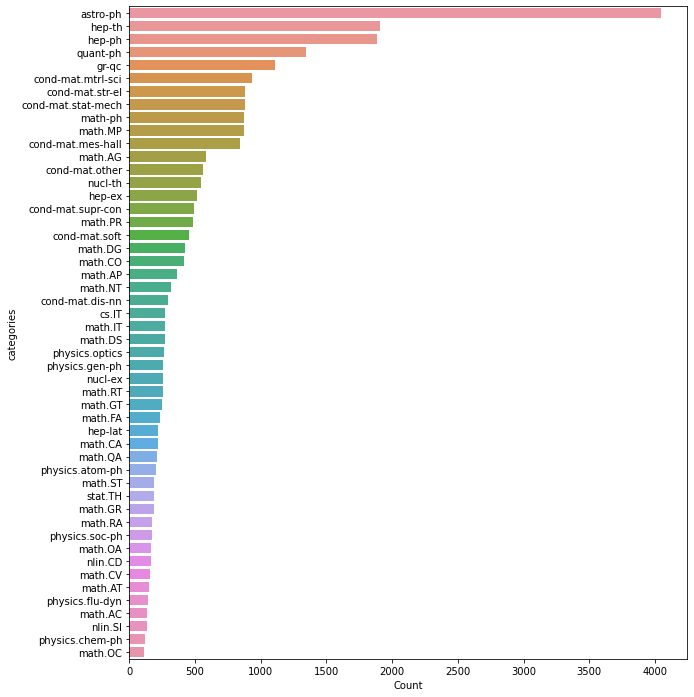

In [120]:
# source: https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/
most_freq_cats = all_cats_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(10,12)) 
ax = sns.barplot(data=most_freq_cats, x= "Count", y = "categories")
plt.show()

So the most frquent categories are **astro-ph** (astro-physics), **hep-th** (high-energy physics - theory), and **hep-ph** (high-energy physics - phenomenology). The complete list of abbreviations exits at https://arxiv.org/category_taxonomy.

Now we are interested in distribution of the number of categories per article.

In [18]:
num_cats = [len(df_20k['cats_split'][row]) for row in range(len(df_20k['cats_split']))]

In [19]:
np.mean(num_cats)

1.5036

Text(0, 0.5, 'number of categories')

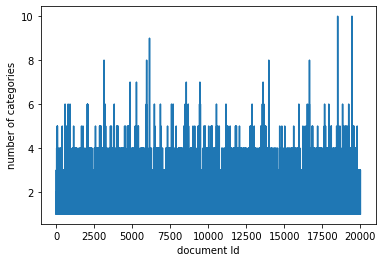

In [20]:
plt.plot(num_cats)
plt.xlabel('document Id')
plt.ylabel('number of categories')

So the maximum number of categories for an article is 10, and on average each article is tagged by 1.5 categories.

Text(0, 0.5, 'count')

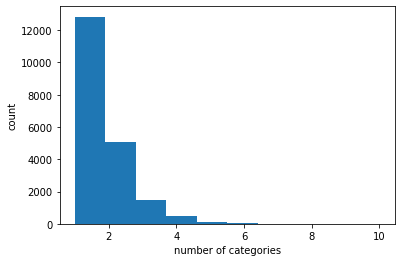

In [122]:
plt.hist(num_cats)
plt.xlabel('number of categories')
plt.ylabel('count')

What about the abstracts? Let's see.

In [22]:
df_20k['split_abstract'] = df_20k['abstract'].str.split()

In [24]:
len_of_abstracts = df_20k['split_abstract'].str.len()

<AxesSubplot:>

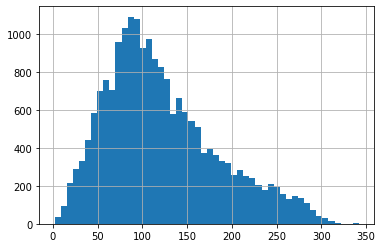

In [25]:
len_of_abstracts.hist(bins=50)

In [26]:
max(len_of_abstracts)

342

Therefore most articles have an abstract with a length of around 100 words, and the maximum number of words for an abstract is 342 words.

## Preparation of the dataset for the classification model

In order to have less number of labels in our dataset, we decide to only consider the general category of each article, and remove the subcategory labels. In the dataset, the subcategories are specified with a "." notation.

For instance, 'cs.AI' means this article belongs to AI subcategory of cs (computer science) field.

Let's prepare the general categoty column for the classification model:

In [124]:
df_20k['general_category'] = df_20k['cats_split'].apply(lambda x:[a.split('.')[0] for a in x])

In [125]:
df_20k.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,cats_split,general_category
0,704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,NaN,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[['Balázs', 'C.', ''], ['Berger', 'E. L.', '']...",[hep-ph],[hep-ph]
1,704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,NaN,NaN,NaN,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[['Streinu', 'Ileana', ''], ['Theran', 'Louis'...","[math.CO, cs.CG]","[math, cs]"
2,704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",NaN,NaN,NaN,physics.gen-ph,NaN,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[['Pan', 'Hongjun', '']]",[physics.gen-ph],[physics]
3,704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,NaN,NaN,NaN,math.CO,NaN,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[['Callan', 'David', '']]",[math.CO],[math]
4,704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,NaN,"Illinois J. Math. 52 (2008) no.2, 681-689",NaN,NaN,math.CA math.FA,NaN,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[['Abu-Shammala', 'Wael', ''], ['Torchinsky', ...","[math.CA, math.FA]","[math, math]"


In [31]:
unique_gen_cat = df_20k['general_category'].map(set)
gen_cats = df_20k['general_category'].sum()
unique_gen_cats = set(gen_cats)
len(unique_gen_cats)

19

Now the number of categories is reduced to 19 general category. Let's see how they are distibuted:

In [126]:
all_gen_cats = nltk.FreqDist(gen_cats) 
all_gen_cats_df = pd.DataFrame({'categories': list(all_gen_cats.keys()), 
                              'Count': list(all_gen_cats.values())})

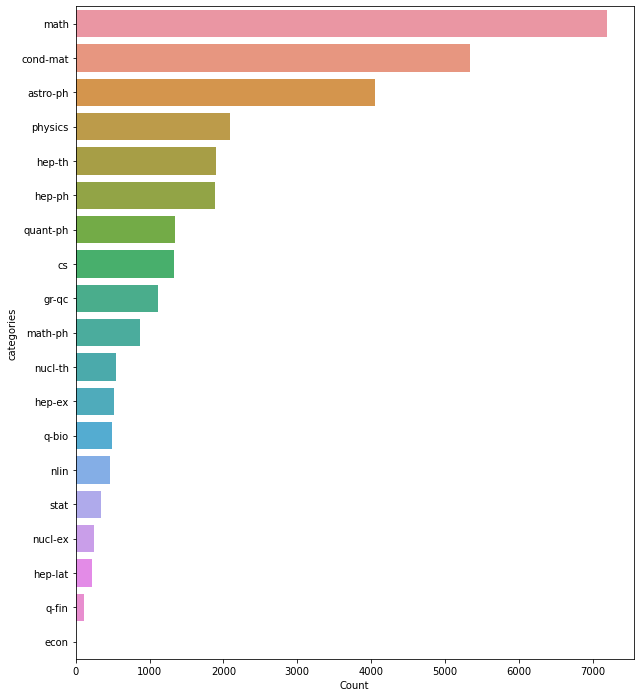

In [127]:
most_freq_gen_cats = all_gen_cats_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(10,12)) 
ax = sns.barplot(data=most_freq_gen_cats, x= "Count", y = "categories")
plt.show()

In [35]:
all_gen_cats_df

,categories,Count
0,hep-ph,1882
1,math,7198
2,cs,1334
3,physics,2088
4,cond-mat,5341
5,gr-qc,1109
6,astro-ph,4054
7,hep-th,1907
8,hep-ex,516
9,nlin,465


Now there are more sample for each category. But still some categoties have just a few hundared samples. The **econ** category has only three samples in the dataset which is not enough. So we decide to load more data. In the next section we use Dask, which is libarary to efficiently load large datasets and scales well for large data machine learning tasks

Let's save the processed dataset for now.

In [128]:
df_20k.to_csv('../input/arxiv_20krows_train.csv', index=False)

## loading data using Dask

In [37]:
# many parts are inspired by: https://www.kaggle.com/kobakhit/eda-and-multi-label-classification-for-arxiv
import dask.bag as db
import json

docs = db.read_text('../input/archive/arxiv-metadata-oai-snapshot.json').map(json.loads)

In [38]:
docs

dask.bag<loads, npartitions=1>

How many articles are in the dataset?

In [39]:
docs.count().compute()

1974617

Let's look at the first sample:

In [40]:
docs.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

In [41]:
# Submissions by datetime
get_latest_version = lambda x: x['versions'][-1]['created']

Now we select only the articles submitted after 2021.

In [42]:
# get only necessary fields
trim = lambda x: {'id': x['id'],
                  'title': x['title'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract']}
# filter for papers published on or after 2020-01-01
columns = ['id','category','abstract']
docs_df = (docs
             .filter(lambda x: int(get_latest_version(x).split(' ')[3]) > 2020)
             .map(trim)
             .compute())

# convert to pandas
docs_df = pd.DataFrame(docs_df)

# add general category. we are going to use as our target variable
docs_df['general_category'] = docs_df.category.apply(lambda x:[a.split('.')[0] for a in x])

In [60]:
docs_df

,id,title,category,abstract,general_category
0,0704.0479,The affine part of the Picard scheme,"[math.AG, math.KT]",We describe the maximal torus and maximal un...,"[math, math]"
1,0705.4060,C*- Algebras and Thermodynamic Formalism,"[math.DS, math.OA]",We present a detailed exposition (for a Dyna...,"[math, math]"
2,0706.2239,Infinitesimal Castelnuovo Theory in Abelian Va...,[math.AG],The purpose of this article is to show that ...,[math]
3,0706.3282,Unified products for braided Lie bialgebras. A...,"[math.QA, math.RA]",We construct unified products for braided Li...,"[math, math]"
4,0707.4296,Infrared renormalization of two-loop integrals...,[hep-ph],We describe details of the renormalization o...,[hep-ph]
...,...,...,...,...,...
201334,physics/0701101,Submitting Jobs on Grid,[physics.comp-ph],This is an user's introduction to grid using...,[physics]
201335,physics/0701308,Boltzmann's Concept of Reality,"[physics.hist-ph, gr-qc, physics.pop-ph, physi...",In this article we describe and analyze the ...,"[physics, gr-qc, physics, physics]"
201336,physics/9903027,Matter and Space with Torsion,"[physics.gen-ph, physics.class-ph]",General equations of the unified field theor...,"[physics, physics]"
201337,quant-ph/0010065,Artificial Orbitals and a Solution to Grover's...,[quant-ph],By allowing measurements of observables othe...,[quant-ph]


About 200k articles are selected. Now let's plot the number of samples per category.

In [84]:
# plot paper distribution by category
source = pd.DataFrame(sample_df.iloc[:,2:].apply(sum)).reset_index().rename(columns = {0:'count'})
ptotalText = alt.Text('PercentOfTotal:Q', format = '.2%')

chart = alt.Chart(source).transform_joinaggregate(
    TotalPapers='sum(count)',
).transform_calculate(
    PercentOfTotal="datum.count / datum.TotalPapers"
).mark_bar().encode(
    x = 'index',
    y = 'count',
    tooltip = ['index','count', ptotalText]
).properties(
    title='arXiv Papers by Category, after 2021-01-01',
    width = 800
)

# add percentage labels
chart = chart + chart.mark_text(
    align='center',
    baseline='middle',
    dx= 3,  # Nudges text to right so it doesn't appear on top of the bar,
    dy = -5
).encode(
    text = ptotalText
) 

chart

alt.LayerChart(...)

So we have at least 500 samples for each category in this dataset. We save the dataset for modelling in the next step.

In [77]:
sample_df.to_csv('../input/sample_df_2021.csv', index=False)